# Acceptance model for B02JpsiKS

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import ROOT
from ROOT import (RooArgSet,
                  RooCategory,
                  RooRealVar,
                  RooDataSet,
                  RooPlot,
                  RooFit,
                  RooStats,
                  RooArgList,
                  RooFormulaVar)

from ROOT import (TFile, 
                  TH1D, 
                  TH2D, 
                  TCanvas, 
                  gStyle, 
                  TLine, 
                  TTree)

import math
import itertools
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from root_pandas import read_root
import pandas as pd
            
sys.path.append('/home/vmueller/repos/')
from dopy.doroot.root_utils import read_roodataset_from_tree, plot_pulls, build_tchain_from_files
from dopy.doplot.plotting import Plotter, Plot
import dopy.doroot.rootnotes 
from dopy.doplot.selection import add_log_to_dataframe, add_max_to_dataframe, add_min_to_dataframe

In [2]:
dataset_dir = '/fhgfs/users/chasenberg/data/2015_2016_merged/jpsimumuks'
 
#new dataset
dataset_file_name= 'Bd2JpsiKS_final_sw.root'
dataset_tree_name = 'Bd2JpsiKS'
dataset_file_name = os.path.join(dataset_dir, dataset_file_name) 
dataset_file_name = '/fhgfs/groups/e5/lhcb/analysis/B2CC/Bd2JpsiKS_run2/FT_calib/Bd2JpsiKS_final_sw_FTcalibrated_FTcombined_FTcombined.root'

In [3]:
dataset_file = TFile(dataset_file_name)
ROOT.SetOwnership(dataset_file, False)

dataset_tree = dataset_file.Get(dataset_tree_name)
ROOT.SetOwnership(dataset_tree, False) 

In [4]:
obsTime     = RooRealVar('B0_FitPVConst_tau_flat', 'obsTime', 0,0.00025, 0.015, 'ns')
obsTimeErr = RooRealVar("B0_FitPVConst_tauErr_flat", "obsTimeErr", 0,-0.001,0.001, "ns")
sweight_sig  = RooRealVar("sweight_sig", "sweight_sig",0 ,-100000,1000000000)
idxPV = RooRealVar("idxPV", "idxPV", 0,0,0)

obsTagOS = RooCategory("B0_TAGDECISION_OS_new", "obsTagOS")
obsTagOS.defineType("B0b", -1)
obsTagOS.defineType("B0",  +1)
obsTagOS.defineType("noTag", 0)

obsEtaOS = RooRealVar('B0_TAGOMEGA_OS_new',"obsEtaOS", 0,0.5)

ROOT.SetOwnership(obsTime, False)
ROOT.SetOwnership(obsTimeErr, False)
ROOT.SetOwnership(sweight_sig, False)
ROOT.SetOwnership(idxPV, False)

data = ROOT.TFile(dataset_file_name)
tree_data = data.Get('Bd2JpsiKS') 
tree_data.GetEntries()
ntupleVarSet =  RooArgSet(obsTime,obsTimeErr,sweight_sig,idxPV, obsTagOS,obsEtaOS)#,B0_FitPVConst_MinIPCHI2anyPV_flat)
data = RooDataSet('data','data',ntupleVarSet,RooFit.Import(tree_data), RooFit.WeightVar("sweight_sig"))
#data = RooDataSet('data_set', 'data_set', tree_data, ntupleVarSet,"", "signal_sw")
ROOT.SetOwnership(data,False)

print('Number of entries: '+ str(data.numEntries()))

Number of entries: 159554


In [5]:
data.isWeighted()

True

In [6]:
subdir = '/home/chasenberg/plots/decaytime/'
plot_dir    = os.path.join(subdir, 'plots')
results_dir = os.path.join(subdir, 'results')
plot_file   = os.path.join(plot_dir, 'all_plots.pdf')

if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

### Build acceptance model

In [7]:
from ROOT import gSystem
gSystem.Load("libRooFit.so")
gSystem.Load("/home/vmueller/repos/dopy/dolib/acceptances/libAcceptances")

0

In [8]:
from ROOT import RooCubicSplineFun
from ROOT import RooResolutionModel 

In [9]:
from ROOT import std
knots = std.vector("double")(5)
knots[0]=(obsTime.getMin()) # 0.0
knots[1]=(0.0003)
knots[2]=(0.0009)
#knots[3]=(0.0007)
knots[3]=(0.004)
#knots[3]=(0.0011)
#knots[5]=(0.013)
knots[4]=(obsTime.getMax()) # 18.0

In [10]:
print(obsTime.getMin(),obsTime.getMax(),len(knots))

0.00025 0.015 5


In [11]:
knotlist = RooArgList("knotlist")
ROOT.SetOwnership(knotlist, False)

# This is needed because 2 extra coefficients are needed
# (assert statement)
for i in range(0,len(knots)+1): # len(knots)+2
    binname = "parTimeAccCSpline" + str(i)
    bintitle = "h_{" + str(i) + "}"
    var = RooRealVar(binname, bintitle,0.01*i,3)
    print(var.getVal())
    #print(str(var.GetName()))
    ROOT.SetOwnership(var, False)
    knotlist.add(var)
    
knotlist.add(knotlist[len(knots)])  

accspline = RooCubicSplineFun("accspline", "Spline Acceptance", obsTime, knots, knotlist)
ROOT.SetOwnership(accspline, False)
#RooCubicSplineFun()

1.5
1.505
1.51
1.515
1.52
1.525


## Fix spline parameters 

In [12]:
parTimeAccCSpline0 = RooRealVar("parTimeAccCSpline0","h_{0}", 6.9989e-04)
parTimeAccCSpline1 = RooRealVar("parTimeAccCSpline1","h_{1}", 1.0000e-02)
parTimeAccCSpline2 = RooRealVar("parTimeAccCSpline2","h_{2}", 1.8739e+00)
parTimeAccCSpline3 = RooRealVar("parTimeAccCSpline3","h_{3}", 3.0000e+00)
parTimeAccCSpline4 = RooRealVar("parTimeAccCSpline4","h_{4}", 3.0000e+00)
parTimeAccCSpline5 = RooRealVar("parTimeAccCSpline5","h_{5}", 1.9418e+00)

ROOT.SetOwnership(parTimeAccCSpline0, False)
ROOT.SetOwnership(parTimeAccCSpline1, False)
ROOT.SetOwnership(parTimeAccCSpline2, False)
ROOT.SetOwnership(parTimeAccCSpline3, False)
ROOT.SetOwnership(parTimeAccCSpline4, False)
ROOT.SetOwnership(parTimeAccCSpline5, False)

knotlist = RooArgList("knotlist")
ROOT.SetOwnership(knotlist, False)
knotlist.add(parTimeAccCSpline0)
knotlist.add(parTimeAccCSpline1)
knotlist.add(parTimeAccCSpline2)
knotlist.add(parTimeAccCSpline3)
knotlist.add(parTimeAccCSpline4)
knotlist.add(parTimeAccCSpline5)

knotlist.add(knotlist[len(knots)])  

accspline = RooCubicSplineFun("accspline", "Spline Acceptance", obsTime, knots, knotlist)
ROOT.SetOwnership(accspline, False)
#RooCubicSplineFun()

### Build resolution model

In [13]:
from ROOT import RooGaussEfficiencyModel
from ROOT import RooEffResAddModel

In [14]:
from ROOT import RooGaussian, RooAddPdf, RooEffResAddModel,RooGaussEfficiencyModel, RooGaussModel, RooAddModel, RooSimultaneous
from ROOT import (RooArgSet,
                  RooCategory,
                  RooRealVar,
                  RooDataSet,
                  RooPlot,
                  RooFit,
                  RooStats,
                  RooArgList,
                  RooFormulaVar)

from ROOT import (TFile, 
                  TH1D, 
                  TH2D, 
                  TCanvas, 
                  gStyle, 
                  TLine, 
                  TTree)



############################################################################################################
############################################################################################################

parResCondMean  = RooRealVar('parResCondMean', 'parResCondMean', 0)
ROOT.SetOwnership(parResCondMean, False)

parResCond_a_1 = RooRealVar('parResCond_a_1', 'parResCond_a_1',0.007)
ROOT.SetOwnership(parResCond_a_1, False)
parResCond_b_1 = RooRealVar('parResCond_b_1', 'parResCond_b_1',  2.99717e-05)
ROOT.SetOwnership(parResCond_b_1, False)


parResCond_a_2 = RooRealVar('parResCond_a_2', 'parResCond_a_2',1.29732e-01)
ROOT.SetOwnership(parResCond_a_2, False)
parResCond_b_2 = RooRealVar('parResCond_b_2', 'parResCond_b_2', 6.80000e-05)
ROOT.SetOwnership(parResCond_b_2, False)


parResCond_a_3 = RooRealVar('parResCond_a_3', 'parResCond_a_3', 0)
ROOT.SetOwnership(parResCond_a_3, False)
parResCond_b_3 = RooRealVar('parResCond_b_3', 'parResCond_b_3',4.00000e-04)
ROOT.SetOwnership(parResCond_b_3, False)





#Definition and calculation of sigma's, related linearly on the decaytime error from the ntuple 
parResCondSigma_1 = RooFormulaVar('parResCondSigma_1', '@0*@1+@2', RooArgList(parResCond_a_1, obsTimeErr, parResCond_b_1))
ROOT.SetOwnership(parResCondSigma_1, False)

parResCondSigma_2 = RooFormulaVar('parResCondSigma_2', '@0*@1+@2', RooArgList(parResCond_a_2, obsTimeErr, parResCond_b_2))
ROOT.SetOwnership(parResCondSigma_2, False)

parResCondSigma_3 = RooFormulaVar('parResCondSigma_3', '@0*@1+@2', RooArgList(parResCond_a_3, obsTimeErr, parResCond_b_3))
ROOT.SetOwnership(parResCondSigma_3, False)
 


#Fractions of particular PDF's  
parResCondFrac_1 = RooRealVar('parResCondFrac_1', 'parResCondFrac_1', 0.650000)
ROOT.SetOwnership(parResCondFrac_1, False)
parResCondFrac_2 = RooRealVar('parResCondFrac_2', 'parResCondFrac_2', 0.346972)
ROOT.SetOwnership(parResCondFrac_2, False)
 

pdfEffModel1 = RooGaussEfficiencyModel('pdfEffModel1', 'pdfEffModel1', obsTime, accspline, parResCondMean, parResCondSigma_1)
ROOT.SetOwnership(pdfEffModel1, False)
pdfEffModel2 = RooGaussEfficiencyModel('pdfEffModel2', 'pdfEffModel2', obsTime, accspline,  parResCondMean, parResCondSigma_2)
ROOT.SetOwnership(pdfEffModel2, False)
pdfEffModel3 = RooGaussEfficiencyModel('pdfEffModel3', 'pdfEffModel3', obsTime,  accspline, parResCondMean, parResCondSigma_3)
ROOT.SetOwnership(pdfEffModel3, False) 
 
pdfRes = RooEffResAddModel('pdfRes', 'pdfRes', RooArgList(pdfEffModel1,pdfEffModel2, pdfEffModel3), RooArgList(parResCondFrac_1, parResCondFrac_2))
ROOT.SetOwnership(pdfRes, False)
pdfRes.Print('t')

In [15]:
parResCond_a_1.getVal(),parResCond_a_2.getVal(),parResCond_a_3.getVal()

(0.007, 0.129732, 0.0)

In [16]:
parResCond_b_1.getVal(),parResCond_b_2.getVal(),parResCond_b_3.getVal()

(2.99717e-05, 6.8e-05, 0.0004)

### Build RooBDecay

In [17]:
'''from ROOT import RooBDecay
from ROOT import RooSimultaneous,RooUnblindUniform

parTimeTau = RooRealVar("parTimeTau", "#it{#tau}", 0.001520)
#, 0.00150, 0.001540) #1.520 +- 0.004ps
dgamma = RooRealVar("dgamma", "#it{#tau}", 0.0)
dmass = RooRealVar("dmass", "#it{#tau}", 0.0005064)

f1 = RooRealVar("f1", "f1", 1)
f2 = RooRealVar("f2", "f2", 0)

f3 = RooRealVar("dgamma", "f3", 0.0001,0,1)
f4 = RooRealVar("dgamma", "f4", 0.1,0,1)

f3_blind = RooUnblindUniform("c","c","parameter-c",2,f3)
f4_blind = RooUnblindUniform("s","s", "sin2betarun2", 2,f4)

ROOT.SetOwnership(parTimeTau, False)

pdfDecayTime = RooBDecay("pdfDecayTime", "pdfDecayTime", obsTime, parTimeTau,dgamma,f1,f2,f3_blind,f4_blind, dmass, pdfRes, RooBDecay.SingleSided)

ROOT.SetOwnership(pdfDecayTime, False)
'''

'from ROOT import RooBDecay\nfrom ROOT import RooSimultaneous,RooUnblindUniform\n\nparTimeTau = RooRealVar("parTimeTau", "#it{#tau}", 0.001520)\n#, 0.00150, 0.001540) #1.520 +- 0.004ps\ndgamma = RooRealVar("dgamma", "#it{#tau}", 0.0)\ndmass = RooRealVar("dmass", "#it{#tau}", 0.0005064)\n\nf1 = RooRealVar("f1", "f1", 1)\nf2 = RooRealVar("f2", "f2", 0)\n\nf3 = RooRealVar("dgamma", "f3", 0.0001,0,1)\nf4 = RooRealVar("dgamma", "f4", 0.1,0,1)\n\nf3_blind = RooUnblindUniform("c","c","parameter-c",2,f3)\nf4_blind = RooUnblindUniform("s","s", "sin2betarun2", 2,f4)\n\nROOT.SetOwnership(parTimeTau, False)\n\npdfDecayTime = RooBDecay("pdfDecayTime", "pdfDecayTime", obsTime, parTimeTau,dgamma,f1,f2,f3_blind,f4_blind, dmass, pdfRes, RooBDecay.SingleSided)\n\nROOT.SetOwnership(pdfDecayTime, False)\n'

In [18]:
from ROOT import RooBDecay
from ROOT import RooSimultaneous, RooUnblindUniform

f0 = RooRealVar("f0", "f0", 1, 0, 2)
f0.setConstant()
f1 = RooRealVar("f1", "f1", 0, -1, 1)
f1.setConstant()

parS = RooRealVar("parS", "#it{S}",  0.7, -1, 1)
parC = RooRealVar("parC", "#it{C}", 0, -1, 1)

parS_ub = RooUnblindUniform("parS_ub", "parS_ub", "Sin2beta2017!", 2, parS)
parC_ub = RooUnblindUniform("parC_ub", "parC_ub", "Sin2beta2017!", 2, parC)

eta_average = RooRealVar("eta_average", "eta_average", 0.352, 0.352, 0.352)
eta_average.setConstant()
parTimeTau = RooRealVar("parTimeTau", "#it{#tau}", 0.001520)#, 1.520, 1.520) #1.520 +- 0.004ps
parDm = RooRealVar("parDm", "parDm", 506.5)
parDGamma = RooRealVar("parDGamma", "parDGamma", 0)

f2 = RooFormulaVar("f2", "+1.0*@0*(1-2*@1)*@2", RooArgList(obsTagOS, eta_average, parC_ub))
f3 = RooFormulaVar("f3", "-1.0*@0*(1-2*@1)*@2", RooArgList(obsTagOS, eta_average, parS_ub))


pdfDecayTime = RooBDecay("simPdf", "simPdf", obsTime, parTimeTau, parDGamma, f0, f1, f2, f3, parDm, pdfRes, RooBDecay.SingleSided)

ROOT.SetOwnership(pdfDecayTime, False)

In [19]:
results_dir = '/home/chasenberg/plots/acceptance/results/'

parameters_file_name  = 'params_cond.txt'
parameters_init_name  = parameters_file_name.replace('.txt', '_init.txt')
parameters_final_name = parameters_file_name.replace('.txt', '_final.txt')

if os.path.exists(os.path.join(results_dir, parameters_init_name)):
    print('INFO: Reading parameters from configfile '  + os.path.join(results_dir, parameters_init_name), flush=True)
    pdfDecayTime.getParameters(data).readFromFile(os.path.join(results_dir, parameters_init_name))
else:
    print('INFO: configfile... '  + os.path.join(results_dir, parameters_init_name) + ' does not exist', flush=True)
    

INFO: Reading parameters from configfile /home/chasenberg/plots/acceptance/results/params_cond_init.txt


In [20]:
cond_argset = RooArgSet(obsTimeErr)    

fit_result = pdfDecayTime.fitTo(data, 
                                    RooFit.NumCPU(6),
                                    RooFit.Minimizer('Minuit','minimize'),
                                    RooFit.Hesse(True),
                                    RooFit.Save(True),
                                    RooFit.ConditionalObservables(cond_argset)) 

In [21]:
fit_result.Print("v")

In [22]:
parS_ub.getVal(),parS.getError()

(0.9708461271054489, 0.02532029853481338)

In [23]:
if fit_result:
    fit_result.Print('v')
    fit_result.correlationMatrix().Print('v')
    if fit_result.status()==0:
        print('INFO: Fit converged')
    else:
        print('INFO: Status '+str(fit_result.status()))
    print('INFO: Fit complete', flush=True)
else:
    print('ERROR: There is no fitresult', flush=True)
 
final_params_file = os.path.join(results_dir, parameters_final_name)
pdfRes.getParameters(data).writeToFile(final_params_file)

INFO: Fit converged
INFO: Fit complete


### Plot RooBDecay

INFO: Start plotting
INFO: Finish plotting


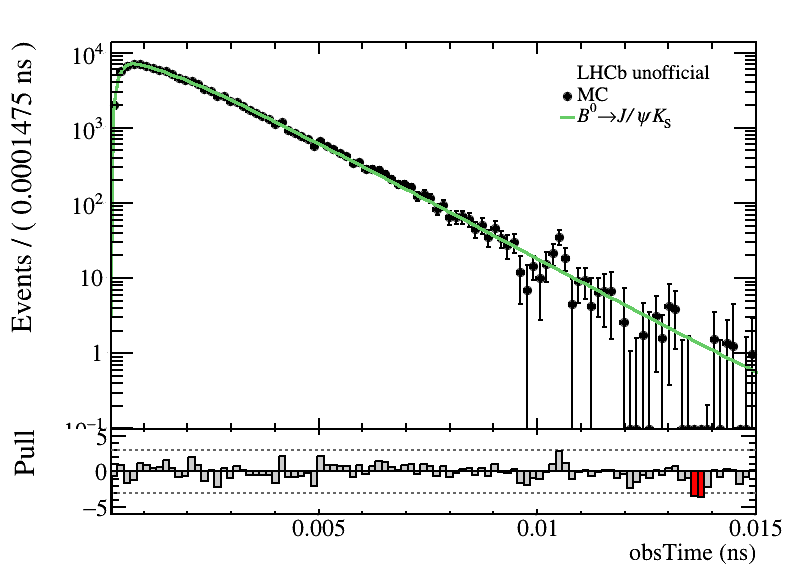

In [24]:
print('INFO: Start plotting', flush=True)
from ROOT import TColor
from root_utils.lhcb_style import set_lhcb_style # Set basic LHCb plot style
set_lhcb_style()   

decay_set  = ROOT.RooArgSet(pdfDecayTime.getComponents().find('simPdf'))
ROOT.SetOwnership(decay_set, False)

# Prepare frame
canvas = TCanvas('canvas', 'canvas', 1000, 600)
ROOT.SetOwnership(canvas, False)

plot_frame = obsTime.frame(ROOT.RooFit.Range(0.00025, 0.015), ROOT.RooFit.Bins(100))
#plot_frame.SetMinimum(-100)

ROOT.SetOwnership(plot_frame, False)

data.plotOn(plot_frame, ROOT.RooFit.Name('data'))
pdfDecayTime.plotOn(plot_frame, RooFit.ProjWData(RooArgSet(obsTimeErr), data, True), RooFit.LineColor(410), ROOT.RooFit.Name('decay_fit'))

### Add additional informations to the plot
text_size = 0.05
# Create TLegend
legend = ROOT.TLegend(0.7, 0.7, 0.80, 0.85)
#legend = ROOT.TLegend(0.7, 0.30, 0.80, 0.5)
ROOT.SetOwnership(plot_frame, False)
legend.AddEntry(0,"LHCb unofficial", "")
legend.AddEntry(plot_frame.findObject('data'), 'MC', 'p')
legend.AddEntry(plot_frame.findObject('decay_fit'), '#it{B}^{0}#rightarrow#it{J/#psi}#it{K}_{#kern[-0.3]{S}}', 'l')
legend.SetTextSize(text_size)

plot_frame.GetYaxis().SetRangeUser(0.1, plot_frame.GetMaximum()*1.2)

# Plot pulls
plotname = 'decaytime_data_blinded'
can,_ = plot_pulls(plotname, plot_frame, drawables=[legend], save_path= subdir + '/plots/', logy=True)
print('INFO: Finish plotting', flush=True)
can

In [25]:
parS.getError()

0.02532029853481338

## Acceptance 

In [26]:
nbins = 50
time_min = obsTime.getMin()
time_max = obsTime.getMax()

from ROOT import TH1D
hist_obsTime = TH1D('hist_obsTime', 'hist_obsTime', nbins, time_min, time_max)
ROOT.SetOwnership(hist_obsTime, False)

for i in range(data.numEntries()):
    hist_obsTime.Fill(data.get(i).getRealValue('obsTime'))
    
canvas = TCanvas('canvas', 'canvas', 1000, 600)
ROOT.SetOwnership(canvas, False)
hist_obsTime.Sumw2()
hist_obsTime.Draw()
#canvas   

TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: canvas


In [27]:
from ROOT import TRandom3

expo = TRandom3(1337)
hist_exp = TH1D('hist_exp', 'hist_exp', nbins, time_min, time_max)

for i in range(0,nbins):
    hist_exp.SetBinContent(i,data.numEntries()*np.exp(-(time_min+(i+0.5)*(time_max-time_min)/nbins)/1.520))

hist_exp.Sumw2()
hist_exp.Draw()
#canvas

In [28]:
hist_obsTime.Sumw2()
hist = TH1D(hist_obsTime)
hist.Divide(hist_exp)
norm_divided = hist.GetSumOfWeights()
hist.Scale(1/100)
hist.Draw()
#canvas

TH1D::Sumw2:0: RuntimeWarning: Sum of squares of weights structure already created


In [29]:
acc_int = accspline.createIntegral(RooArgSet(obsTime))
print(acc_int.getVal())
scale_bin = (time_max-time_min)/nbins
scale = (1/acc_int.getVal())*scale_bin
print(scale)

0.036030709998624996
0.00818746008644453


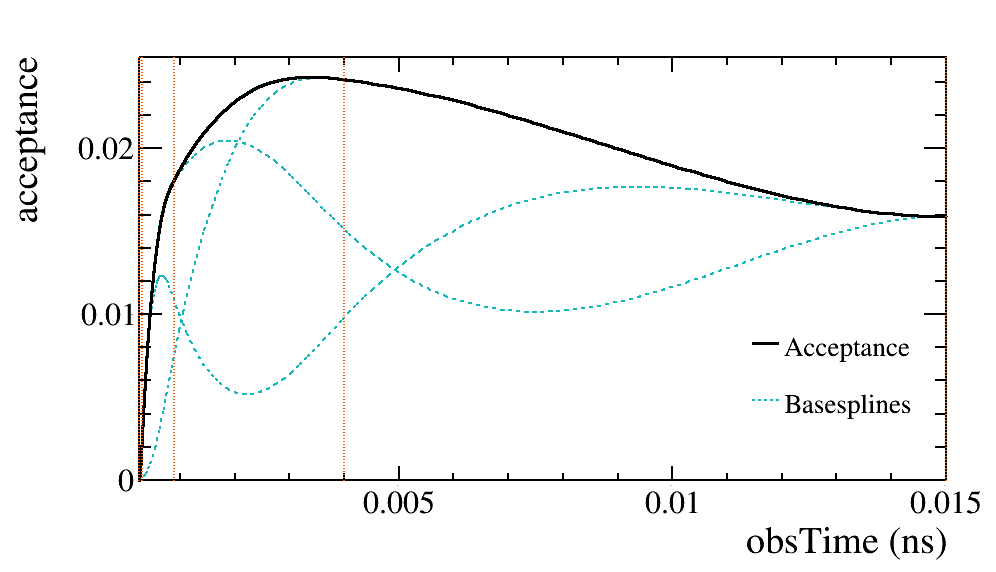

In [30]:
from ROOT import TLine
from ROOT import TLegend

canvas_scaled = TCanvas('canvas_scaled', 'canvas_scaled', 1000, 600)
time_frame = obsTime.frame()
accspline.plotOn(time_frame, RooFit.Normalization(scale),RooFit.LineColor(1))
#time_frame.addTH1(hist)

coeffs = accspline.coefficients()
basesplines = []
lines = []
baselist = RooArgList()

for i,knot in enumerate(knots):
    baselist = coeffs.snapshot()
    for j in range(baselist.getSize()):
        if j==i:
            baselist[i] = coeffs[i] #RooRealVar('blub_'+str(i)+'_'+str(j), 'blub_'+str(i)+'_'+str(j), 1.0)#
            ROOT.SetOwnership(baselist[i], False)
        else:
            baselist[i].setVal(0.0)   
    baselist.Print()        
    basespline = RooCubicSplineFun('csplines'+str(i),'csplines'+str(i), obsTime, knots, baselist)
    basesplines.append(basespline)
    basespline.plotOn(time_frame, RooFit.Normalization(scale), RooFit.LineColor(226), RooFit.LineStyle(2), RooFit.LineWidth(2), RooFit.Name('basespline'))
    line = TLine(knot, 0, knot, time_frame.GetMaximum())
    line.SetLineColor(96)
    line.SetLineStyle(3)
    lines.append(line)

accspline.plotOn(time_frame, RooFit.Normalization(scale),RooFit.LineColor(1), RooFit.Name('accspline'))
time_frame.GetYaxis().SetTitle('acceptance')
time_frame.Draw()
for line in lines:
    line.Draw()
    
### Add additional informations to the plot
text_size = 0.05
# Create TLegend
legend = ROOT.TLegend(0.75, 0.25, 0.90, 0.45)
#legend.AddEntry(time_frame.findObject('hist_obsTime'), 'MC #it{B}^{0}#rightarrow#it{#psi}(2S)#it{K}_{#kern[-0.3]{S}}', 'p')
legend.AddEntry(time_frame.findObject('accspline'), 'Acceptance', 'l')
legend.AddEntry(time_frame.findObject('basespline'), 'Basesplines', 'l')
legend.SetTextSize(text_size) 
legend.Draw()
#canvas_scaled.SaveAs('/home/chasenberg/plots/acceptance/acceptance_data_bestPV.pdf') 
canvas_scaled 

In [31]:
coeffs = accspline.coefficients()
print(coeffs.snapshot()[1])

<ROOT.RooRealVar object ("parTimeAccCSpline1") at 0xb86bd40>


In [32]:
for i,knot in enumerate(knots):
    baselist = coeffs.snapshot()
    for j in range(baselist.getSize()):
        if j==i:
            baselist[i] = coeffs[i] #RooRealVar('blub_'+str(i)+'_'+str(j), 'blub_'+str(i)+'_'+str(j), 1.0)#
            ROOT.SetOwnership(baselist[i], False)
        else:
            baselist[i].setVal(0.0)   
    baselist.Print()
    print(baselist.)

SyntaxError: invalid syntax (<ipython-input-32-55672d005d82>, line 10)